In [2]:
import numpy as np
import pandas as pd
from nltk.tokenize import regexp_tokenize
import nltk
import string
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
import requests
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
def get_links(extension= ""):
    # Scrape each page
    URL = "https://www.gutenberg.org/ebooks/bookshelf/40?sort_order=title" + extension
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, 'html.parser')
    # Extract relevant data
    links = soup.find_all(class_="link")
    title = soup.find_all(class_="title")
   # Store data in table
    if extension == "":
        books = {
            "title": [l.get_text() for l in title[2:]],
            "link": ["https://www.gutenberg.org/"+l.get("href") for l in links[2:]]
        }
    else:
        books = {
            "title": [l.get_text() for l in title],
           "link": ["https://www.gutenberg.org/"+l.get("href") for l in links]
        }
    df= pd.DataFrame(books, columns = ["title", "link"])
    return df

In [4]:
# Store links and title from each page in one dataframe
page_data = [get_links()] + [get_links(f"&start_index={25*i+1}") for i in range(1,8)] 
gutenberg_links = pd.concat(page_data)

In [5]:
gutenberg_links

,title,link
0,Aeneid of Virgil,https://www.gutenberg.org//ebooks/22456
1,"Æneid of Virgil, Translated into English Verse",https://www.gutenberg.org//ebooks/18466
2,Aeneis (Latin),https://www.gutenberg.org//ebooks/227
3,Aeneis. English,https://www.gutenberg.org//ebooks/228
4,Aesop's Fables,https://www.gutenberg.org//ebooks/28
...,...,...
5,"Works of the Right Honourable Edmund Burke, Vo...",https://www.gutenberg.org//ebooks/15701
6,World's Greatest Books — Volume 04 — Fiction,https://www.gutenberg.org//ebooks/10921
7,World's Greatest Books — Volume 06 — Fiction,https://www.gutenberg.org//ebooks/11180
8,World's Greatest Books — Volume 10 — Lives and...,https://www.gutenberg.org//ebooks/12572


In [14]:
harvard_classics = pd.DataFrame(columns=["index", "author", "text"])

for i, link in enumerate(gutenberg_links["link"]):
    # Get the HTML link of the txt file
    pg = requests.get(link)
    soup = BeautifulSoup(pg.content, 'html.parser')
    # Only keep English books
    lang = soup.find("tr", {"property":"dcterms:language"}).get_text()
    # Only take text files
    file_type = soup.find("td", {"property": "dcterms:type"}).get_text()
    if "English" in lang and file_type == "Text":
        result = soup.find_all(class_="noscreen")
        r = result[-2].get_text()
        # Open txt file
        text_file = requests.get(r)
        sp = BeautifulSoup(text_file.content, 'html.parser')
        # Get full text in the page
        full_text = sp.get_text().split("***", 2)[2]
        # Extract and append data
        try:
            harvard_classics = harvard_classics.append({
                "index": i,
                "author": full_text.split("Author: ",1)[1].split("\r",1)[0], 
                "date": soup.find("td", {"itemprop": "datePublished"}).get_text(),
                "title": gutenberg_links["title"].iloc[i],
                "text": full_text,
                "tokens": word_tokenize(full_text)[200:]
            }, ignore_index= True)
        except:
            pass
    else:
        continue


IndexError: list index out of range

In [148]:
harvard_classics

,index,author,text,title
0,0,Virgil,"\r\n\r\n\r\nE-text prepared by David Clarke, L...",Aeneid of Virgil
1,1,Virgil,\r\n\r\n\r\n\r\n\r\nProduced by Ron Swanson\r\...,"Æneid of Virgil, Translated into English Verse"
2,3,Virgil,\r\n\r\n\r\n\r\n\r\n THE AENEID\r\n\r\n\r\n by...,Aeneis. English
3,4,Aesop,\r\n\r\n\r\n**********************************...,Aesop's Fables
4,6,Aeschylus,"\r\n\r\n\r\n\r\n\r\nProduced by Paul Murray, C...",Agamemnon of Aeschylus\r
...,...,...,...,...
124,180,Edmund Burke,"\r\n\r\n\r\n\r\n\r\nProduced by Paul Murray, S...","Works of the Right Honourable Edmund Burke, Vo..."
125,181,Editors: Arthur Mee and J.A. Hammerton,"\r\n\r\n\r\n\r\n\r\nProduced by John Hagerson,...",World's Greatest Books — Volume 04 — Fiction
126,182,Various,"\r\n\r\n\r\n\r\n\r\nProduced by John Hagerson,...",World's Greatest Books — Volume 06 — Fiction
127,183,Various,"\r\n\r\n\r\n\r\n\r\nProduced by John Hagerson,...",World's Greatest Books — Volume 10 — Lives and...


# Sentence Length

In [149]:
def parse(t, i):
    # Remove all punctuation except .?!
    tk = re.sub(r'[^\w\d\.\!\?\'\s]+', ' ', t) 
    # Split into sentences
    sent = [regexp_tokenize(sent, "[\w']+") for sent in nltk.sent_tokenize(tk)]
    # Store in dataframe
    df = pd.DataFrame({
        "sentence": sent,
        "index": np.full(len(sent), i)
    })
    return df[50:-1]

In [150]:
# Clean text for each book
frames = [parse(t, i) for i, t in enumerate(harvard_classics["text"])]
sent_length = pd.concat(frames)
# Calculate sentence length
sent_length["length"] = sent_length["sentence"].map(len)
# Group sentence length by book
grouped_sent_length =sent_length.groupby("index")["length"].apply(list)
# Append to table
harvard_classics["length"] = grouped_sent_length

In [183]:
# Tokenize full text
harvard_classics["token"] = harvard_classics["text"].apply(regexp_tokenize, args=("[\w']+",))

In [184]:
harvard_classics

,index,author,text,title,length,token
0,0,Virgil,"E-text prepared by David Clarke, Lisa Reige...",Aeneid of Virgil,"[25, 22, 26, 22, 18, 27, 17, 49, 40, 18, 32, 1...","[E, text, prepared, by, David, Clarke, Lisa, R..."
1,1,Virgil,Produced by Ron Swanson EVERYMAN'S L...,"Æneid of Virgil, Translated into English Verse","[10, 18, 90, 22, 41, 39, 50, 13, 55, 13, 24, 1...","[Produced, by, Ron, Swanson, EVERYMAN'S, LIBRA..."
2,3,Virgil,THE AENEID by Virgil Translated by ...,Aeneis. English,"[16, 26, 27, 10, 60, 18, 28, 13, 35, 36, 23, 8...","[THE, AENEID, by, Virgil, Translated, by, John..."
3,4,Aesop,*******************************************...,Aesop's Fables,"[53, 20, 23, 23, 25, 6, 3, 4, 11, 1, 4, 9, 24,...","[EBOOK, 30, WAS, ONE, OF, PROJECT, GUTENBERG'S..."
4,6,Aeschylus,"Produced by Paul Murray, Charles Bidwell ...",Agamemnon of Aeschylus\r,"[12, 21, 6, 25, 21, 31, 28, 1, 1, 19, 11, 5, 1...","[Produced, by, Paul, Murray, Charles, Bidwell,..."
...,...,...,...,...,...,...
124,180,Edmund Burke,"Produced by Paul Murray, Susan Skinner an...","Works of the Right Honourable Edmund Burke, Vo...","[19, 45, 8, 58, 35, 38, 31, 11, 12, 38, 18, 33...","[Produced, by, Paul, Murray, Susan, Skinner, a..."
125,181,Editors: Arthur Mee and J.A. Hammerton,"Produced by John Hagerson, Kevin Handy an...",World's Greatest Books — Volume 04 — Fiction,"[38, 7, 20, 37, 17, 6, 13, 30, 57, 8, 47, 29, ...","[Produced, by, John, Hagerson, Kevin, Handy, a..."
126,182,Various,"Produced by John Hagerson, Kevin Handy an...",World's Greatest Books — Volume 06 — Fiction,"[9, 8, 7, 70, 9, 7, 15, 14, 23, 31, 40, 48, 32...","[Produced, by, John, Hagerson, Kevin, Handy, a..."
127,183,Various,"Produced by John Hagerson, Kevin Handy an...",World's Greatest Books — Volume 10 — Lives and...,"[51, 55, 10, 22, 6, 45, 9, 17, 26, 7, 1, 40, 3...","[Produced, by, John, Hagerson, Kevin, Handy, a..."


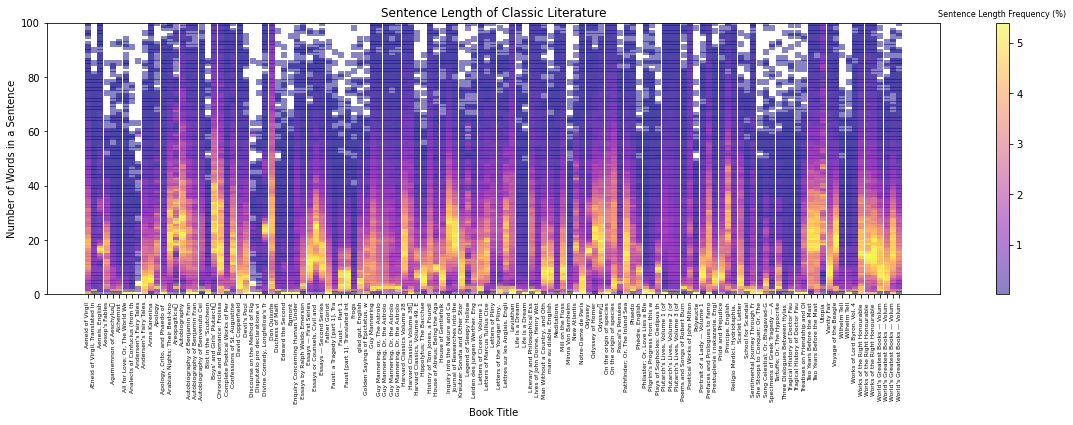

In [258]:
plt.figure(figsize = (20,5))

# Plot each distribution of sentence length as a vertical plot
for i, text in enumerate(harvard_classics["length"]):
    count = Counter(text) # count number of sentence lengths
    key = list(count.keys()) 
    c = np.array(list(count.values()))
    norm_c = c/sum(c)*100
    plt.scatter(x= np.full(len(key),i), y =key , c = norm_c, cmap = "plasma", alpha = 0.5, marker = "s",
        linewidths = 0) # remove circle outline

# Constrain maximum number of words
plt.ylim([0,100])

# Set x labels
book_name = [title[:30] for title in harvard_classics["title"]]
plt.xticks(ticks = np.arange(0, len(harvard_classics)), labels= book_name ,rotation= 90, fontsize=6)

# Format colour bar
cbar = plt.colorbar()
cbar.ax.set_title("Sentence Length Frequency (%)", fontsize= 8)

plt.ylabel("Number of Words in a Sentence")
plt.xlabel("Book Title")
plt.title("Sentence Length of Classic Literature")
plt.show()

# Verb Tense Proportion

In [251]:
verb = [ "VB", "VBG", "VBD","VBN", "VBP", "VBZ"]
verb_name = [ "Base", "Continuous","Past", "Past Participle", "Present", "Present (3rd)"]
df_postag = pd.DataFrame(columns = verb_name)

for index, row in harvard_classics.iterrows():
    token = nltk.pos_tag(row["token"])
    word, tag = zip(*token)
    count = Counter(tag)
    prop = np.array([count[x] for x in verb])
    norm_prop = prop/sum(prop)*100
    df_postag.loc[index] = norm_prop


In [239]:
df_postag

,VBD,VB,VBG,VBN,VBP,VBZ
0,20.282038,20.983884,11.002080,12.464258,15.947492,19.320250
1,25.716923,21.337488,9.849403,10.668744,16.150251,16.277191
2,20.287876,22.620470,9.984639,6.895375,21.505376,18.706264
3,39.862915,23.701299,10.606061,10.966811,8.838384,6.024531
4,18.801867,22.769710,9.776971,12.759336,15.663900,20.228216
...,...,...,...,...,...,...
124,17.733683,25.368154,7.096143,20.741202,14.321306,14.739512
125,42.498456,19.041984,9.055361,16.140152,7.635316,5.628730
126,42.036427,18.882000,8.481883,15.525092,8.840341,6.234257
127,39.472695,18.675831,8.543199,18.836922,7.157816,7.313537


C:\Users\lilia\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\textpath.py:65: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
C:\Users\lilia\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\lilia\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


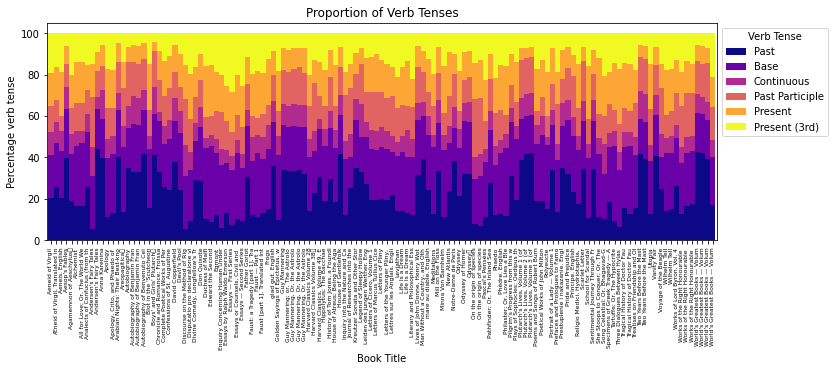

In [257]:
df_postag[verb_name].plot(kind= "bar", stacked = True, figsize = (12, 4), width = 1, colormap = "plasma")
plt.xticks(ticks = np.arange(0, len(harvard_classics)), labels= book_name ,rotation= 90, fontsize=6)
plt.xlabel("Book Title")
plt.ylabel("Percentage verb tense")
plt.title("Proportion of Verb Tenses")
plt.legend(bbox_to_anchor=(1.0, 1.0), title = "Verb Tense")
plt.show()